# ADS 507: **Flight Analytics**

**US Airport Weather Cancellations ETL**

----

## Setup

### Load proper libraries/login variables

In [1]:
import pymysql
import pandas as pd
import sqlite3
import warnings
import seaborn as sns
import numpy as np
import dash
import geopandas as gpd
from shapely.geometry import Point, Polygon
import os 
import folium
from folium import plugins
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es
import matplotlib.pyplot as plt
from datetime import datetime as dt
import itertools

from folium import plugins
from folium.plugins import HeatMap

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

userName = 'sqluser'
userPass = 'password'

### Create a new database 

in which we will create our schema for related tables for our final output

In [2]:
conn=pymysql.connect(host='localhost',port=int(3306), user=userName, passwd=userPass, db='airline')

cur = conn.cursor()

In [3]:
# Run ONCE only:

cur.execute('CREATE DATABASE domestic_flight_weather_team1')
conn.commit()
cur.close()



### Connect to the local copy of airline database:

In [4]:
conn=pymysql.connect(host='localhost',port=int(3306), user=userName, passwd=userPass, db='airline')

### Rename main airline table:

In [5]:
# RUN ONCE, and then no more since the name has already been changed:

cur = conn.cursor()

cur.execute('ALTER TABLE on_time_on_time_performance_2016_1 RENAME to on_time_performance_2016')
conn.commit()


## Extract Step:

Extraction of all tables of relevance like l_airpot, l_airline_id, l_cancellation, and on_time_performance_2016 come from the airline database, while the weather data comes from a CSV file.

### Extract the AirportCode/City table 'l_airport':

In [5]:

airport_codes_table = pd.read_sql_query('SELECT * FROM l_airport', conn)



### Extract AirlineID/Carrier Table into dataframe:

In [6]:
airlineID_carrier_table = pd.read_sql_query('SELECT * FROM l_airline_id', conn)


### Extract Cancellation Code table into dataframe:

In [7]:
CancellationCode_table = pd.read_sql_query('SELECT * FROM l_cancellation', conn)


### Extract main table on_time_performance_2016:

In [8]:
airline_flights_table = pd.read_sql_query('SELECT * FROM on_time_performance_2016', conn)


### Read in weather csv file:

In [ ]:
## RUN ONCE:
### Load the Data in its original form:
WeatherUS = pd.read_csv('WeatherEvents_Jan2016-Dec2021.csv')
WeatherUS = WeatherUS[ WeatherUS[ 'StartTime(UTC)' ].str.contains( '2016' )==True ]
WeatherUS = WeatherUS.drop(['LocationLat','LocationLng','TimeZone','County','ZipCode'], axis=1)
WeatherUS.to_csv('WeatherUS_2016.csv')

In [9]:
Weather_df = pd.read_csv('WeatherUS_2016.csv')


## Transform Step:

### Modify CRSDepTime column in airline database to be in Time format:

#### Debug purposes:

In [7]:
# Need to convert the scheduled departure time in the flights data
# to the proper format to then be added to the flight date
# and then convert that field to a datetime...

# Here, we see the original format of the scheduled departure
# time:

##airline_flights_table['CRSDepTime'].head(6610)

0       1100
1       1100
2       1100
3       1100
4       1100
        ... 
6605      59
6606      59
6607      59
6608      59
6609      59
Name: CRSDepTime, Length: 6610, dtype: int64

In [8]:
# The original flightdate format:

##airline_flights_table['FlightDate'].head(6610)

0       2016-01-06
1       2016-01-07
2       2016-01-08
3       2016-01-09
4       2016-01-10
           ...    
6605    2016-01-09
6606    2016-01-11
6607    2016-01-12
6608    2016-01-13
6609    2016-01-14
Name: FlightDate, Length: 6610, dtype: object

#### Conversions:

In [10]:
# First convert the scheduled departure time to a string:

airline_flights_table['CRSDepTime'] = airline_flights_table['CRSDepTime'].astype('string')


In [11]:
# Fill CRSDepTime with the right amount of zeros to the left and right
# depending on the original length of the field:

for x in range(0,len(airline_flights_table)):
    if len(airline_flights_table.loc[x,'CRSDepTime']) == 4:
        airline_flights_table.loc[x,'CRSDepTime']=airline_flights_table.loc[x,'CRSDepTime'].ljust(6,'0')
    if len(airline_flights_table.loc[x,'CRSDepTime']) == 2:
        airline_flights_table.loc[x,'CRSDepTime']=airline_flights_table.loc[x,'CRSDepTime'].ljust(4,'0')
        airline_flights_table.loc[x,'CRSDepTime']=airline_flights_table.loc[x,'CRSDepTime'].rjust(6,'0')
    else:
        airline_flights_table.loc[x,'CRSDepTime']=airline_flights_table.loc[x,'CRSDepTime'].ljust(5,'0')
        airline_flights_table.loc[x,'CRSDepTime']=airline_flights_table.loc[x,'CRSDepTime'].rjust(6,'0')



In [12]:
# Change CRSDepTime to the TIME format:

for x in range(len(airline_flights_table)):
    airline_flights_table.loc[x,'CRSDepTime']=pd.to_datetime(airline_flights_table.loc[x,'CRSDepTime'], format='%H%M%S').strftime('%H:%M:%S')


In [13]:
# Concatenate the FLight Date with CRSDepTIme TIME for flights data:

airline_flights_table['FlightDate'] = airline_flights_table['FlightDate'].astype(str) + ' ' + airline_flights_table['CRSDepTime'].astype(str) 


#### Confirm changes:

In [10]:
# Resulting time format of the scheduled departure time:

##airline_flights_table['CRSDepTime'].head(6610)

0       11:00:00
1       11:00:00
2       11:00:00
3       11:00:00
4       11:00:00
          ...   
6605    00:59:00
6606    00:59:00
6607    00:59:00
6608    00:59:00
6609    00:59:00
Name: CRSDepTime, Length: 6610, dtype: string

In [11]:
# Resulting FlightDate now with the scheduled departure
# time added on so we can find the proper weather conditions
# associated with each and every flight:

##airline_flights_table['FlightDate'].head(6610)

0       2016-01-06 11:00:00
1       2016-01-07 11:00:00
2       2016-01-08 11:00:00
3       2016-01-09 11:00:00
4       2016-01-10 11:00:00
               ...         
6605    2016-01-09 00:59:00
6606    2016-01-11 00:59:00
6607    2016-01-12 00:59:00
6608    2016-01-13 00:59:00
6609    2016-01-14 00:59:00
Name: FlightDate, Length: 6610, dtype: object

### Drop the K in airport codes for Weather dataframe:

In [14]:
# dropping K values in front of the Airport Code Column so they can match
# up with the airline flights airport codes:

Weather_df['AirportCode'] = Weather_df['AirportCode'].str[1:]



### Clean up Column names in Weather dataframe:

In [15]:
# Simple rename for ease in coding:

Weather_df.rename(columns = {'StartTime(UTC)':'StartTime_UTC','EndTime(UTC)':'EndTime_UTC'}, inplace = True)


### Clean up airport dataframe:

In [16]:
# Split up the "Description" field in the original aiport dataframe
# So that fields mean something more - the airport code is followed by
# the related airport name and it's city and state:

airport_codes_table[['City_State', 'Airport']] = airport_codes_table['Description'].str.split(':', expand=True)
airport_codes_table= airport_codes_table.drop('Description', axis=1)
airport_codes_table[['City', 'State']] = airport_codes_table['City_State'].str.split(',', n=1, expand=True)
airport_codes_table= airport_codes_table.drop('City_State', axis=1)


In [17]:
airport_codes_table['City']=airport_codes_table['City'].astype('string')
airport_codes_table['Airport']=airport_codes_table['Airport'].astype('string')
airport_codes_table['State']=airport_codes_table['State'].astype('string')
airport_codes_table['Code']=airport_codes_table['Code'].astype('string')

### Create dataframe for NEW FEATURE that combines Weather type and severity: 

In [18]:
# Find all possible unique values for weather type
# and weather severity in the weather dataframe:

Type_unique=Weather_df['Type'].unique()
Severity_unique=Weather_df['Severity'].unique()


In [19]:
# Generate all possible combinations for weather
# type and severity so that we assign a code called weather_code
# This feature can be used by data science teams to see if there is a
# relationship with cancellations and the combination of such 
# weather conditions:

all_combinations = list(itertools.product(Type_unique, Severity_unique))
Weather_comb = pd.DataFrame(all_combinations, columns=['Type','Severity'])

### Add ENGINEERED FEATURE Weather_Code to Weather dataframe:

In [20]:
# Runtime is longest here:

weather_code = []

for i in Weather_df.index:
    for x in Weather_comb.index:
        if (Weather_df.loc[i, 'Type'] == Weather_comb.loc[x,'Type']) & (Weather_df.loc[i, 'Severity'] == Weather_comb.loc[x,'Severity']):
            weather_code.append(x)
 
Weather_df['Weather_code'] = weather_code

## Load Step:

In [22]:
cur = conn.cursor()
cur.execute('USE domestic_flight_weather_team1')
conn.commit()

### Load Weather data to continue transformation in SQL:

In [23]:
#Connect to Database
#con = sqlite3.connect('airline') 
cur = conn.cursor()

# Create Table

cur.execute('CREATE TABLE Airport_Weather(EventID INT, WeatherDate_start DATETIME, WeatherDate_end DATETIME, Airport_id VARCHAR(6), Location_lat FLOAT, Location_long FLOAT, weather_code INT, weather_type VARCHAR(30), weather_severity VARCHAR(20), CONSTRAINT weatherEvent PRIMARY KEY (EventID))')
conn.commit()

In [24]:
# Insert data from csv into new table on certain columns:
# Insert Dataframe into SQL Server:

for index, row in Weather_df.iterrows():
     cur.execute("INSERT INTO Airport_Weather (EventID, WeatherDate_start, WeatherDate_end, Airport_id, Location_lat, Location_long, weather_code, weather_type, weather_severity) values(%s,%s,%s,%s,%s,%s,%s,%s,%s)", 
     (index, row.StartTime_UTC, row.EndTime_UTC, row.AirportCode, row.LocationLat, row.LocationLng, row.Weather_code, row.Type, row.Severity))

conn.commit()
#cur.close()

### Load Airport code/city/state table in new database:

In [25]:
cur.execute('CREATE TABLE airportID_table(Airport_id VARCHAR(10), Airport VARCHAR(100), City VARCHAR(30), State VARCHAR(100), CONSTRAINT Airport_index PRIMARY KEY (Airport_id))')
conn.commit()

In [26]:
for index, row in airport_codes_table.iterrows():
     cur.execute("INSERT INTO airportID_table (Airport_id, Airport, City, State) values(%s,%s,%s,%s)", 
     (row.Code, row.Airport, row.City, row.State))

conn.commit()


### Load Airline ID table in new database:

In [27]:
cur.execute('CREATE TABLE airline_id_table(Airline_id INT, Airline_name VARCHAR(100), CONSTRAINT Airline_id PRIMARY KEY (Airline_id))')
conn.commit()

In [28]:
for index, row in airlineID_carrier_table.iterrows():
     cur.execute("INSERT INTO airline_id_table (Airline_id, Airline_name) values(%s,%s)", 
     (row.Code, row.Description))

conn.commit()


### Load Cancellation Code table in new database:

In [29]:
cur.execute('CREATE TABLE cancellation_code_table(Cancellation_code CHAR, Cancellation_reason VARCHAR(20), CONSTRAINT Cancellation_code PRIMARY KEY (Cancellation_code))')
conn.commit()

In [30]:
for index, row in CancellationCode_table.iterrows():
     cur.execute("INSERT INTO cancellation_code_table (Cancellation_code, Cancellation_reason) values(%s,%s)", 
     (row.Code, row.Description))

conn.commit()


#### Load Weather Type/Severity Table:

In [31]:
cur.execute('CREATE TABLE Weather_TypeSeverity(TypeSeverity INT, Type VARCHAR(20), Severity VARCHAR(20), CONSTRAINT TypeSeverity PRIMARY KEY (TypeSeverity))')
conn.commit()

In [32]:
for index, row in Weather_comb.iterrows():
     cur.execute("INSERT INTO Weather_TypeSeverity (TypeSeverity, Type, Severity) values(%s,%s,%s)", 
     (index, row.Type, row.Severity))

conn.commit()


### Create Table airline_copy with new FlightDate format and only necessary columns loaded into our database:

In [34]:
cur.execute('CREATE TABLE airline_copy(index_flights INT, FlightDate DATETIME, Airline_id INT, Origin VARCHAR(20), Dest VARCHAR(20), CRSDepTime TIME, Canceled INT, Cancellation_code VARCHAR(2), CONSTRAINT index_flights PRIMARY KEY (index_flights))')
conn.commit()

In [35]:
for index, row in airline_flights_table.iterrows():
     cur.execute("INSERT INTO airline_copy (index_flights,flightDate,Airline_id,Origin,Dest,CRSDepTime,Canceled,Cancellation_code) values(%s,%s,%s,%s,%s,%s,%s,%s)", 
     (index, row.FlightDate, row.AirlineID, row.Origin, row.Dest, row.CRSDepTime, row.Cancelled, row.CancellationCode))

conn.commit()

### Join Flight table with Weather data:

JOIN is based on the AIRPORT code matches between weather data and Origin and Dest in on_time_performance_2016.
Date match has to be BETWEEN the start and end dates of the weather data

In [36]:
cur = conn.cursor()

In [38]:
## Focus is on Origin, not destination, here for future implementation if needed

# Generate Destination flight weather table:


## cur.execute('CREATE TABLE Flight_Dest_Weather_Table  AS SELECT a.index_flights, a.FlightDate,  a.Airline_id, a.Dest, m.Location_lat, m.Location_long, a.Canceled, a.Cancellation_code, m.weather_code, m.weather_type as Dest_WeatherType, m.weather_severity as Dest_WeatherSeverity FROM airline_copy as a JOIN airport_weather as m ON a.Dest = m.Airport_id WHERE DATE(a.FlightDate) BETWEEN DATE(m.WeatherDate_start) AND DATE(m.WeatherDate_end) GROUP BY a.index_flights')
## conn.commit()

In [39]:
# Add constraints/keys to the table so this connects our main table to the 
# other related tables in the database:

##cur.execute('ALTER TABLE Flight_Dest_Weather_Table ADD PRIMARY KEY (index_flights)')
##conn.commit()            
##cur.execute('ALTER TABLE Flight_Dest_Weather_Table ADD FOREIGN KEY (Weather_code) REFERENCES Weather_TypeSeverity (TypeSeverity)')
##conn.commit()
##cur.execute('ALTER TABLE Flight_Dest_Weather_Table ADD FOREIGN KEY (Airline_id) REFERENCES airline_id_table (Airline_id)')
##conn.commit()
##cur.execute('ALTER TABLE Flight_Dest_Weather_Table ADD FOREIGN KEY (Cancellation_code) REFERENCES cancellation_code_table (Cancellation_code)')
##conn.commit()
##cur.execute('ALTER TABLE Flight_Dest_Weather_Table ADD FOREIGN KEY (Dest) REFERENCES airportID_table (Airport_id)')
##conn.commit()


In [37]:
# Generate Origin Flight Weather Table:

cur.execute('CREATE TABLE Flight_Origin_Weather_Table  AS SELECT a.index_flights, a.FlightDate,  a.Airline_id, a.Origin, m.Location_lat, m.Location_long, a.Canceled as Canceled, a.Cancellation_code, m.weather_code, m.weather_type, m.weather_severity FROM airline_copy as a JOIN airport_weather as m ON a.Origin = m.Airport_id WHERE DATE(a.FlightDate) BETWEEN DATE(m.WeatherDate_start) AND DATE(m.WeatherDate_end) GROUP BY a.index_flights')
conn.commit()

In [38]:
# Add constraints/keys to the table so this connects our main table to the 
# other related tables in the database:

cur.execute('ALTER TABLE Flight_Origin_Weather_Table ADD PRIMARY KEY (index_flights)')
conn.commit()            
cur.execute('ALTER TABLE Flight_Origin_Weather_Table ADD FOREIGN KEY (Weather_code) REFERENCES Weather_TypeSeverity (TypeSeverity)')
conn.commit()
cur.execute('ALTER TABLE Flight_Origin_Weather_Table ADD FOREIGN KEY (Airline_id) REFERENCES airline_id_table (Airline_id)')
conn.commit()
cur.execute('ALTER TABLE Flight_Origin_Weather_Table ADD FOREIGN KEY (Cancellation_code) REFERENCES cancellation_code_table (Cancellation_code)')
conn.commit()
cur.execute('ALTER TABLE Flight_Origin_Weather_Table ADD FOREIGN KEY (Origin) REFERENCES airportID_table (Airport_id)')
conn.commit()

In [21]:
cur.close()

## Output Vizualizations Setup:

### Download background maps/prep data:

In [63]:
Flight_weather_dataframe = pd.read_sql_query('SELECT * FROM Flight_Origin_Weather_Table', conn)


In [41]:
#USairports_map = gpd.read_file('data/airp_usa.shp')


In [40]:
US_map = gpd.read_file('tl_2017_us_state/tl_2017_us_state.shp')


In [64]:
# Name Latitude and Longitude properly for use in geoplots
# and folium libraries:

Flight_weather_dataframe.rename(columns = {'Location_lat':'lat','Location_long':'long'}, inplace = True)


In [66]:
# convert weather_code into object so the mode is found in subsequent code (as opposed to average, which
# is counter-intuitive as weather_code is a categorical and not a hierarchical/integer value)

Flight_weather_dataframe['weather_code']=Flight_weather_dataframe['weather_code'].astype('object')

In [67]:
# Find the highest frequency of weather conditions for each airport:

airports_subset=Flight_weather_dataframe[['Origin','FlightDate','Canceled','weather_code','weather_type','weather_severity']]
airports_mode=airports_subset.groupby(['Origin']).agg(lambda x:x.value_counts().index[0]).reset_index()



In [68]:
# Find the highest frequency of weather conditions for each airport:

airports_subset2=Flight_weather_dataframe_geo[['Origin','lat','long']]
airports_loc=airports_subset2.groupby(['Origin']).agg(lambda x:x.value_counts().index[0]).reset_index()

In [69]:
# Attach the latitude/long data to the dataframe
# with the most common weather conditions for each airport:

airports_viz=pd.merge(airports_mode, airports_loc, on = "Origin")


In [70]:
# Once again, add the geometry field:

geometry = [Point(xy) for xy in zip(airports_viz['long'], airports_viz['lat'])]
airports_viz_geo = gpd.GeoDataFrame(airports_viz, 
                          geometry = geometry)

### Simple maps depicting top weather conditions/airport:

#### Top Weather Type per airport with annotations:

0      Annotation(-75.4477, 40.6499, 'ABE')
1      Annotation(-106.615, 35.0417, 'ABQ')
2      Annotation(-98.4138, 45.4436, 'ABR')
3      Annotation(-84.1957, 31.5365, 'ABY')
4       Annotation(-97.2283, 31.618, 'ACT')
                       ...                 
251    Annotation(-95.4024, 32.3541, 'TYR')
252     Annotation(-83.9857, 35.818, 'TYS')
253    Annotation(-83.2739, 30.7763, 'VLD')
254    Annotation(-86.5254, 30.4833, 'VPS')
255    Annotation(-94.3114, 36.2898, 'XNA')
Length: 256, dtype: object

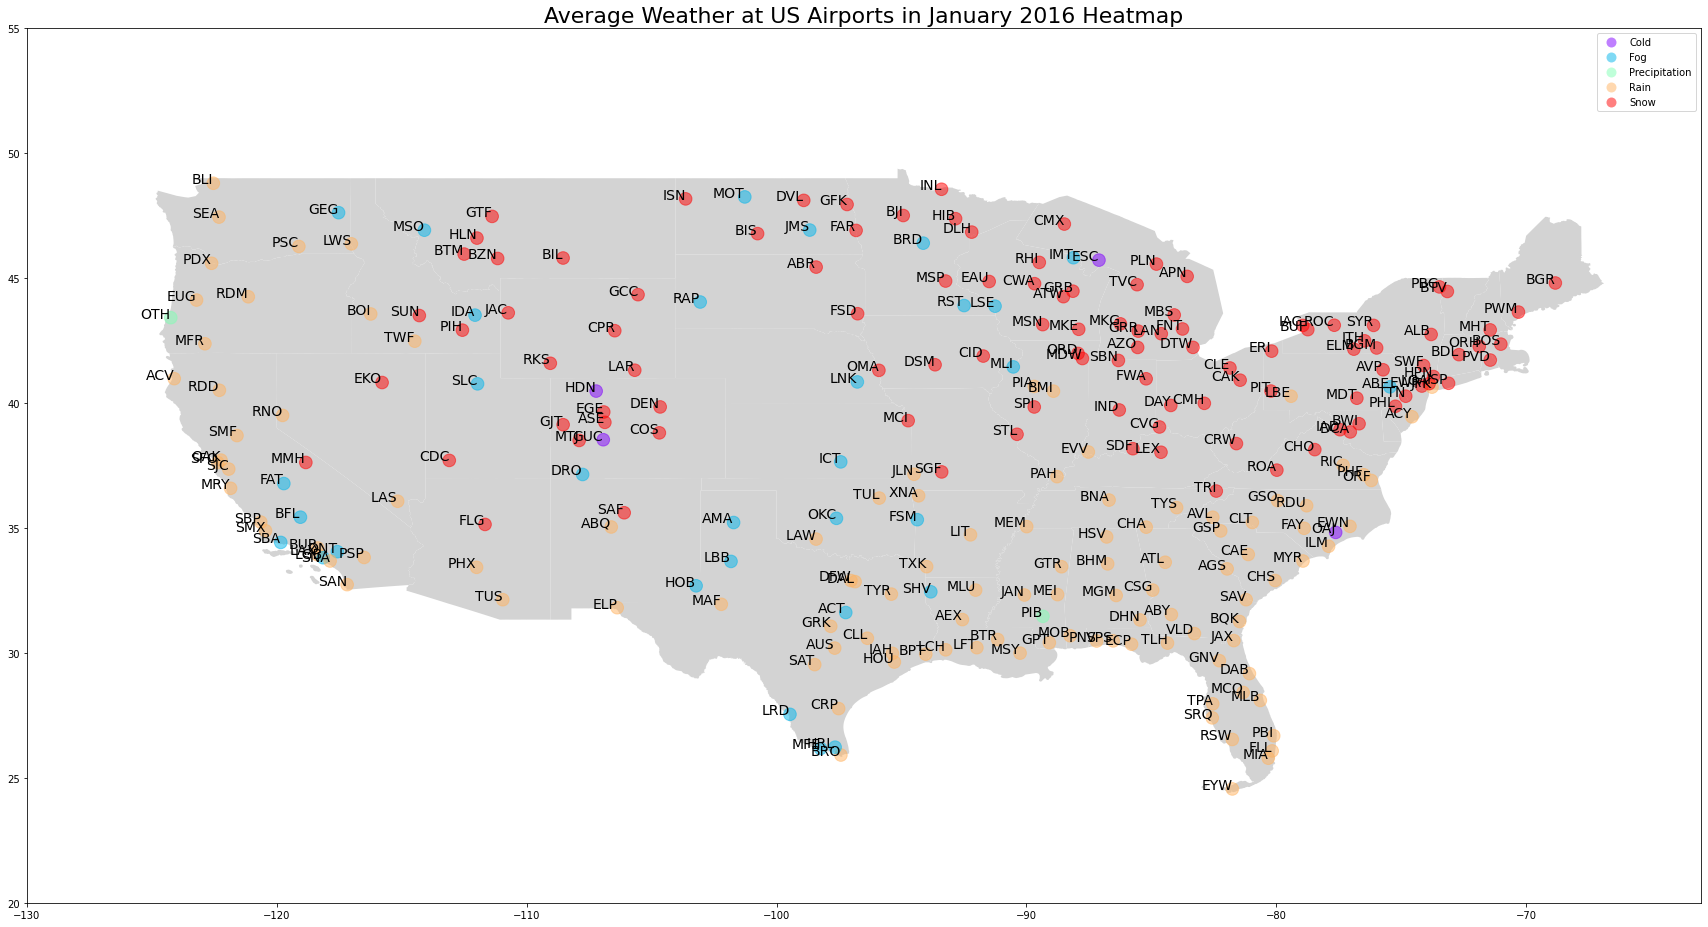

In [71]:
# Plot top weather type on US map for US airports:

fig, ax = plt.subplots(figsize = (30,30))
US_map.plot(ax=ax, color='lightgrey')
airports_viz_geo.plot(column = 'weather_type', ax=ax, colormap='rainbow',
            legend = True, 
            alpha = .5, markersize = 160)
ax.set_title('Average Weather at US Airports in January 2016 Heatmap', fontsize=22)
minx, miny, maxx, maxy = [-130,20,-63,55]
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)



# Kind of messy...
# Annotationb of airport location name:
airports_viz.apply(lambda x: ax.annotate(text=x['Origin'], xy=x.geometry.centroid.coords[0], ha='right',
                                             fontsize=14), axis=1)

# Error on this annotation:
#for idx, row in airports_viz_geo.iterrows():
#    ax.annotate(text=row.Origin, xy=row.geometry)

### Interactive map SETUP

In [72]:
# Import data from EarthPy

data = et.data.get_data('colorado-flood')

# Set working directory to earth-analytics
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

#### Background Map to be used:

In [121]:
# Create a map using the Map() function and the coordinates for Boulder, CO
m = folium.Map(location=[40.0150, -105.2705])



#### Set up data to generate total cancellations/airport

In [76]:
# Add field called "geometry" to use this data in geoplots:

geometry = [Point(xy) for xy in zip(Flight_weather_dataframe['long'], Flight_weather_dataframe['lat'])]
Flight_weather_dataframe_geo = gpd.GeoDataFrame(Flight_weather_dataframe, 
                          geometry = geometry)

In [74]:
# cancellations per location:
airport_cancellations_rows=(Flight_weather_dataframe_geo['Canceled'] == 1)

airport_viz_cancelled=Flight_weather_dataframe_geo.loc[airport_cancellations_rows]


#### Add Heatmap of total Cancellations per airport:

In [122]:

#from folium import plugins
#from folium.plugins import HeatMap

heat_data = [[row['lat'],row['long']] for index, row in airport_viz_cancelled.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(m)

##m


#### Prepare data to output top weather conditions for the airports that had cancellations (that are present in the heatmap)

In [78]:
cancelled_mode=airport_viz_cancelled[['Origin','FlightDate','weather_code','weather_type','weather_severity','Cancellation_code']]
airport_viz_cancelled_mode=cancelled_mode.groupby(['Origin']).agg(lambda x:x.value_counts().index[0]).reset_index()

#### Incorporate the Cancellation reason description from the Cancellation_code lookup in the CancellationCode_table from the airline database:

In [93]:
airport_viz_cancelled_mode['Cancellation_reason']='unknown'
for index, row in airport_viz_cancelled_mode.iterrows():
    for index2, row2 in CancellationCode_table.iterrows():
        if airport_viz_cancelled_mode.loc[index,'Cancellation_code'] == CancellationCode_table.loc[index2,'Code']:
            airport_viz_cancelled_mode.loc[index,'Cancellation_reason']=CancellationCode_table.loc[index2,'Description']


In [95]:
cancelled_location=airport_viz_cancelled[['Origin','lat','long','geometry']]
airport_viz_cancelled_location=cancelled_location.groupby(['Origin']).agg(lambda x:x.value_counts().index[0]).reset_index()


In [96]:
airports_cancelled_mode_loc=pd.merge(airport_viz_cancelled_mode, airport_viz_cancelled_location, on = "Origin")


## Output Visualization:

In [129]:
for index, row in airports_cancelled_mode_loc.iterrows():
    folium.Marker(
        location=[row.lat, row.long], # coordinates for the marker (Earth Lab at CU Boulder)
        popup= 'Airport: ' + row.Origin + '\nWeather: ' + row.weather_type + '\nCancellation Reason: ' + row.Cancellation_reason,# pop-up label for the marker
        icon=folium.Icon(icon='plane', icon_size=(2,2))
    ).add_to(m)

# Display m
##m

In [130]:
m

In [133]:
#m = folium.Map()
import time
from selenium import webdriver
m.save("Continental_USA_Flight_Cancellations_top_weather_conditions_January_2016.html")